# Imports & dataset loading

In [1]:
from cancerclassification.data import *
from cancerclassification.nn import *
from cancerclassification.swav import *

from sklearn.metrics import accuracy_score
import torch.optim as optim

import seaborn as sns

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
device = (
    "cuda:0" if torch.cuda.is_available() else "cpu"
)  # 0 indicates the GPU you gonna use
print(f"Using {device} device")

Using cuda:0 device


In [3]:
dataset = read_data_TCGA_preprocessed()
idx = generate_indices(dataset)
cancer_dataset = CancerDatasetTCGA(dataset[:, 1:], dataset[:, 0], device)
dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
input_dim = dataloaders[0].dataset.inputs.shape[1] # 57387
output_dim = dataloaders[0].dataset.labels.unique().shape[0] # 20
w = compute_loss_weights(dataset, device)

9352 elements in the dataset
6546 elements in the trainset
1403 elements in the valset
1403 elements in the testset


# Number of prototypes

In [16]:
name = "demo_number_prototypes_tcga"
logger = LogResults(name, ["nprotos"])

nprotos = [10, 20, 40, 60, 80, 100]

for i in range(5):
    for nproto in nprotos:
        
        logger.update_hyps([nproto])
        
        config_swav = {
            "epochs": 200,
            "lr_init": 0.0001,
            "early_stop": 5,
            "coeff": 0.6,
        }
        
        # SwAV training
        
        idx = generate_indices(dataset)
        dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
        net_swav = NetSwav(input_dim, nproto=nproto).to(device)
        train_swav_tcga(config_swav, dataloaders, net_swav, device, config_swav["early_stop"])
        torch.save(net_swav.state_dict(), "data/s12/swav_state_dict_0.pt")
        
        # Finetuning and evaluation
        
        idx = generate_indices(dataset, prop=0.03)
        base_bs = 256
        margin = 0.5
        bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
        dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])
        
        config_nn = {
            "epochs": 200,
            "lr_init": 0.001,
            "early_stop": 5,
        }
        
        for j in range(10):
            net = Net(input_dim, output_dim).to(device)
            transfer_weights(net, f"data/s12/swav_state_dict_0.pt")
            train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger)
            logger.next_run()
            logger.show_progression()
            
        logger.save_csv()

9352 elements in the dataset
6546 elements in the trainset
1403 elements in the valset
1403 elements in the testset
| Epoch:   1/200 | SwAVTrainLoss=1.8446 | SwAVEvalLoss=1.0907 |
| Epoch:   2/200 | SwAVTrainLoss=0.7447 | SwAVEvalLoss=0.5288 |
| Epoch:   3/200 | SwAVTrainLoss=0.3735 | SwAVEvalLoss=0.3174 |
| Epoch:   4/200 | SwAVTrainLoss=0.2562 | SwAVEvalLoss=0.2506 |
| Epoch:   5/200 | SwAVTrainLoss=0.2028 | SwAVEvalLoss=0.2028 |
| Epoch:   6/200 | SwAVTrainLoss=0.1657 | SwAVEvalLoss=0.1984 |
| Epoch:   7/200 | SwAVTrainLoss=0.1485 | SwAVEvalLoss=0.1773 |
| Epoch:   8/200 | SwAVTrainLoss=0.1497 | SwAVEvalLoss=0.1681 |
| Epoch:   9/200 | SwAVTrainLoss=0.1443 | SwAVEvalLoss=0.1343 |
INFO: Early stopping counter 1 of 5
| Epoch:  10/200 | SwAVTrainLoss=0.1245 | SwAVEvalLoss=0.1524 |
INFO: Early stopping counter 2 of 5
| Epoch:  11/200 | SwAVTrainLoss=0.1180 | SwAVEvalLoss=0.1435 |
| Epoch:  12/200 | SwAVTrainLoss=0.1145 | SwAVEvalLoss=0.1313 |
INFO: Early stopping counter 1 of 5
| Epoch:

<AxesSubplot:xlabel='nprotos', ylabel='test_acc'>

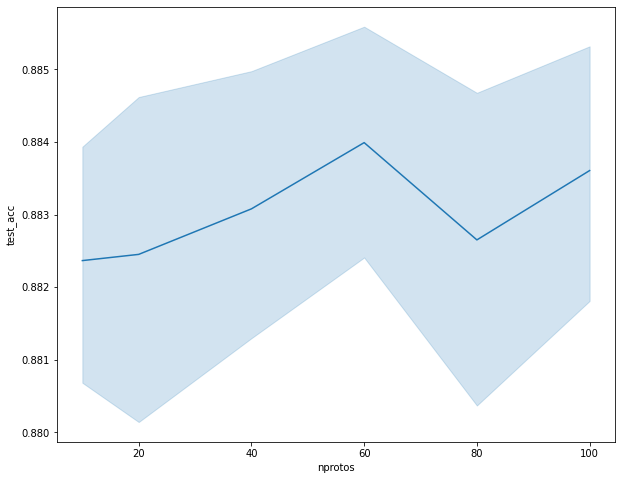

In [9]:
df_results = pd.read_csv("demo_number_prototypes_tcga.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(10, 8))
sns.lineplot(data=df_le, x="nprotos", y="test_acc")

# Epsilon value

In [24]:
name = "demo_epsilon_value_tcga"
logger = LogResults(name, ["epsilon"])

epsilons = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14]

for i in range(5):
    for eps in epsilons:
        
        logger.update_hyps([eps])
        
        config_swav = {
            "epochs": 200,
            "lr_init": 0.0001,
            "early_stop": 5,
            "coeff": 0.6,
        }
        
        # SwAV training
        
        idx = generate_indices(dataset)
        dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
        net_swav = NetSwav(input_dim, nproto=nproto).to(device)
        train_swav_tcga(config_swav, dataloaders, net_swav, device, config_swav["early_stop"], eps=eps)
        torch.save(net_swav.state_dict(), "data/s12/swav_state_dict_0.pt")
        
        # Finetuning and evaluation
        
        idx = generate_indices(dataset, prop=0.03)
        base_bs = 256
        margin = 0.5
        bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
        dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])
        
        config_nn = {
            "epochs": 200,
            "lr_init": 0.001,
            "early_stop": 5,
        }
        
        for j in range(10):
            net = Net(input_dim, output_dim).to(device)
            transfer_weights(net, f"data/s12/swav_state_dict_0.pt")
            train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger)
            logger.next_run()
            logger.show_progression()
            
        logger.save_csv()

9352 elements in the dataset
6546 elements in the trainset
1403 elements in the valset
1403 elements in the testset
| Epoch:   1/200 | SwAVTrainLoss=4.2341 | SwAVEvalLoss=3.4489 |
| Epoch:   2/200 | SwAVTrainLoss=3.0915 | SwAVEvalLoss=2.7729 |
| Epoch:   3/200 | SwAVTrainLoss=2.4912 | SwAVEvalLoss=2.2750 |
| Epoch:   4/200 | SwAVTrainLoss=2.0349 | SwAVEvalLoss=1.8935 |
| Epoch:   5/200 | SwAVTrainLoss=1.6976 | SwAVEvalLoss=1.6698 |
| Epoch:   6/200 | SwAVTrainLoss=1.4623 | SwAVEvalLoss=1.5032 |
| Epoch:   7/200 | SwAVTrainLoss=1.2945 | SwAVEvalLoss=1.4013 |
| Epoch:   8/200 | SwAVTrainLoss=1.1883 | SwAVEvalLoss=1.3089 |
| Epoch:   9/200 | SwAVTrainLoss=1.0978 | SwAVEvalLoss=1.2186 |
| Epoch:  10/200 | SwAVTrainLoss=1.0201 | SwAVEvalLoss=1.1805 |
INFO: Early stopping counter 1 of 5
| Epoch:  11/200 | SwAVTrainLoss=1.0078 | SwAVEvalLoss=1.1828 |
| Epoch:  12/200 | SwAVTrainLoss=0.9582 | SwAVEvalLoss=1.1333 |
| Epoch:  13/200 | SwAVTrainLoss=0.9163 | SwAVEvalLoss=1.1140 |
| Epoch:  14/200

<AxesSubplot:xlabel='epsilon', ylabel='test_acc'>

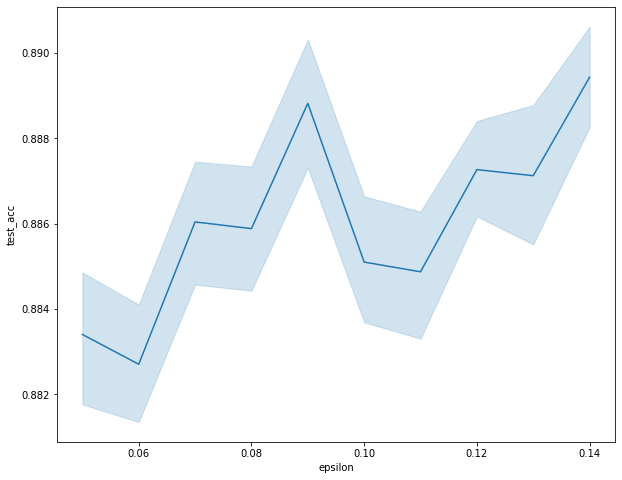

In [8]:
df_results = pd.read_csv("demo_epsilon_value_tcga.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(10, 8))
sns.lineplot(data=df_le, x="epsilon", y="test_acc")

# Augmentation method

In [27]:
name = "demo_augmentation_method_tcga"
logger = LogResults(name, ["coeff", "aug"])

coeffs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
augmentations = ["noise", "mask"]

for i in range(5):
    for coeff in coeffs:
        for aug in augmentations:
            
            logger.update_hyps([coeff, aug])
            
            config_swav = {
                "epochs": 200,
                "lr_init": 0.0001,
                "early_stop": 5,
                "coeff": coeff,
            }
            
            # SwAV training
            
            idx = generate_indices(dataset)
            dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
            net_swav = NetSwav(input_dim, nproto=nproto).to(device)
            train_swav_tcga(config_swav, dataloaders, net_swav, device, config_swav["early_stop"], eps=0.09, method=aug)
            torch.save(net_swav.state_dict(), "data/s12/swav_state_dict_0.pt")
        
            # Finetuning and evaluation

            idx = generate_indices(dataset, prop=0.03)
            base_bs = 256
            margin = 0.5
            bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
            dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])

            config_nn = {
                "epochs": 200,
                "lr_init": 0.001,
                "early_stop": 5,
            }

            for j in range(10):
                net = Net(input_dim, output_dim).to(device)
                transfer_weights(net, f"data/s12/swav_state_dict_0.pt")
                train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger)
                logger.next_run()
                logger.show_progression()

            logger.save_csv()



9352 elements in the dataset
6546 elements in the trainset
1403 elements in the valset
1403 elements in the testset
| Epoch:   1/200 | SwAVTrainLoss=3.6985 | SwAVEvalLoss=3.4267 |
| Epoch:   2/200 | SwAVTrainLoss=3.2262 | SwAVEvalLoss=3.0797 |
| Epoch:   3/200 | SwAVTrainLoss=2.8922 | SwAVEvalLoss=2.8732 |
| Epoch:   4/200 | SwAVTrainLoss=2.6729 | SwAVEvalLoss=2.7029 |
| Epoch:   5/200 | SwAVTrainLoss=2.5345 | SwAVEvalLoss=2.5924 |
| Epoch:   6/200 | SwAVTrainLoss=2.4424 | SwAVEvalLoss=2.6484 |
| Epoch:   7/200 | SwAVTrainLoss=2.3944 | SwAVEvalLoss=2.5050 |
INFO: Early stopping counter 1 of 5
| Epoch:   8/200 | SwAVTrainLoss=2.3423 | SwAVEvalLoss=2.5567 |
| Epoch:   9/200 | SwAVTrainLoss=2.3041 | SwAVEvalLoss=2.4888 |
| Epoch:  10/200 | SwAVTrainLoss=2.2943 | SwAVEvalLoss=2.4590 |
| Epoch:  11/200 | SwAVTrainLoss=2.2600 | SwAVEvalLoss=2.4263 |
| Epoch:  12/200 | SwAVTrainLoss=2.2375 | SwAVEvalLoss=2.3993 |
| Epoch:  13/200 | SwAVTrainLoss=2.2196 | SwAVEvalLoss=2.3951 |
| Epoch:  14/200

<AxesSubplot:xlabel='coeff', ylabel='test_acc'>

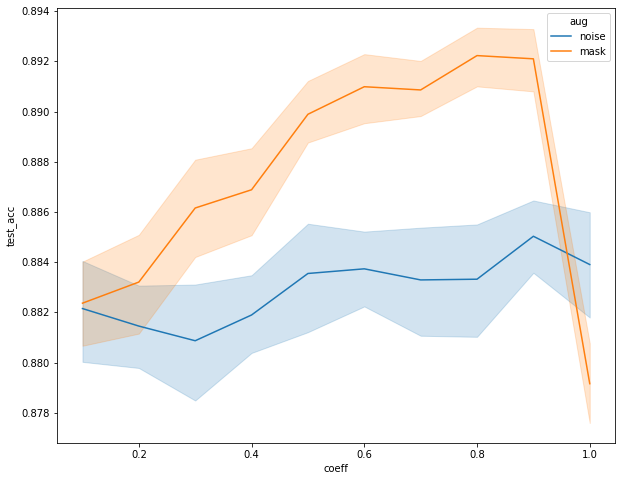

In [7]:
df_results = pd.read_csv("demo_augmentation_method_tcga.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(10, 8))
sns.lineplot(data=df_le, x="coeff", y="test_acc", hue="aug")